### Problem Statement

#### Data 
Included is the data of daily sales by product and daily out-of-stock by product, with some missing days of sales data. You check your tool belt and secure your mapping from products to brands. Searching through a SQL database this box is connected to you also find a comprehensive history of marketing campaigns, but only the start dates and binary campaign features. You’ll have to see if you can use those without prior knowledge of the campaign duration or knowledge of the impact of the features. Wrapping up, you have: 
1. Daily sales data by products (missing some values) 
2. A mapping of products to brands 
3. Daily out-of-stock signal by product 
4. Marketing campaign start dates and binary features for products 
5. Marketing campaign start dates and binary features for entire brands.

#### Goals
Goals Your spawning process gave you open-ended goals. “Leave and bring back value for forecasting.”  Your task is to build a forecasting tool for the parent algorithm. You might also find insights by quantifying the existences of different economic forces in the Ecommerce ecosystem. The decision to focus more on discovering understandable insights or on just building the best tool you can build is up to your preference. 

#### Results

I built a Random Forest model to predict when a given product will go out of stock given the number of days since the last product promotion started, number of days since the last brand promotion started, the cumulative sales on a given day, and the unspecified features from the product and brand promotions (f0 through f29).

The out of bag error for the trained Random Forest for product id 100 was 0.789, the accuracy on the training set was 0.973.

On average, across a random sampling of ~100 products, the model achieved an average hold-out set accuracy of 85%, average F1 score of 0.86, average precision of 0.85, and average recall of 0.86. These are good measures of generalization performance, as they were measured on a 33% hold out set. 

The feature importances from the trained Random Forest showed that in most cases the recency of a product promotion, the cumulative product sales until the day in question were more strongly predictive of a product being out of stock than a brand promotion associated with that product.  The unspecified features of the promotions were not strong predictors of whether a product was out of stock.
 
#### Notes
The existing model could be improved using a GridSearch to scan the parameter space for the Random Forest 
(e.g find the optimal number of estimators, tree depth, max features, gini vs entropy information criterion, etc).

A probabalistic / Bayesian model or survival analysis model may also work well the quantify the probability that a product is about to go out of stock.

#### Housekeeping

In [25]:
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import plot_confusion_matrix
import warnings
from scipy.stats import pearsonr
warnings.filterwarnings("ignore")
%matplotlib inline

#### Load and clean the input data

In [2]:
FEATS = ['f0', 'f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8',
       'f9', 'f10', 'f11', 'f12', 'f13', 'f14', 'f15', 'f16', 'f17', 'f18',
       'f19', 'f20', 'f21', 'f22', 'f23', 'f24', 'f25', 'f26', 'f27', 'f28',
       'f29']

def load_data():
    
    # Load daily product sales
    prod_sales = pd.read_csv('daily_product_sales.csv', index_col = 0)

    # Load daily product out of stock
    prod_oos = pd.read_csv('daily_product_oos.csv', index_col = 0, parse_dates = True)

    # Load product and brand map
    prod_brand_map = pd.read_csv('product_brand_map.csv')
    prod_brand_map.columns = ['product', 'brand']

    # Load brand promotions
    brand_promo = pd.read_csv("brand_promotions.csv", index_col = 'brand', parse_dates = ['start_date'])

    # Load product promotions
    product_promo = pd.read_csv('product_promotions.csv', parse_dates = ['start_date'], index_col = 'product')

    
    # Merge brand promo with brand_product_map
    brand_promo = pd.merge(brand_promo, prod_brand_map, left_index=True, right_on='brand')[['start_date', 'product']+FEATS]
    #brand_promo.index = pd.DatetimeIndex(brand_promo.start_date)
    
    return brand_promo, product_promo, prod_oos, prod_sales
    
    

#### Let's take a closer look at out of stock dataset

In [5]:
brand_promo, product_promo, prod_oos, prod_sales = load_data()

def predict_prod_oos(brand_promo, product_promo, prod_oos, prod_sales, product_id):

# Transpose the dataframe so that dates are indexes
    prod_oos = prod_oos.T
    prod_oos.index = pd.DatetimeIndex(prod_oos.index)

    prod_sales = prod_sales.T
    prod_sales.index = pd.DatetimeIndex(prod_sales.index)

    prod_sales = prod_sales[[product_id]]
    prod_oos = prod_oos[[product_id]]

    # Merge product sales and out of stock

    df = pd.merge(prod_oos, prod_sales, left_index = True, right_index = True)
    df.columns = ['oos', 'sales']

    df['cumulative_sales'] = df['sales'].cumsum()

    df['day'] = 1
    df['i'] = ((df['oos'] == 1) & (df['oos'].shift(1) == 0)).cumsum().values

    df['cum_sales_since_oos'] = df.groupby('i')['sales'].cumsum()

    X = df[['oos', 'sales', 'cum_sales_since_oos', 'i', 'cumulative_sales']]

    X['days_since_oos'] = X.assign(instock = 1 - X['oos']).groupby('i')['instock'].cumsum().values.astype(int)
    X.dropna(inplace = True)

    # Merge in product promos
    df = pd.merge(X, product_promo.loc[product_id], left_index = True, right_on = 'start_date', how = 'outer')
    #df = pd.merge(X, product_promo.loc[product_id], left_on = 'start_date', right_on = 'start_date', how = 'outer')
    df.fillna(0, inplace = True)
    df['prod_promo_start'] = (df[FEATS].sum(axis=1) > 0)
    df['j'] = ((df['prod_promo_start']) & ~(df['prod_promo_start'].shift(1).fillna(0))).cumsum().values
    df['days_since_prod_promo'] = df.assign(no_promo_start=1 - df.prod_promo_start.fillna(0).astype(int)).groupby('j')['no_promo_start'].cumsum().values


    # Merge in brand promos, if they exist
    if product_id in set(brand_promo['product'].values):
        Y = pd.merge(df, brand_promo[brand_promo['product']==100], left_on='start_date', right_on='start_date', how='outer')
        Y.fillna(0, inplace=True)
        Y['brand_promo_start'] = (Y[[f+'_y' for f in FEATS]].sum(axis=1) > 0)
        Y['j'] = ((Y['brand_promo_start']) & ~(Y['brand_promo_start'].shift(1).fillna(0))).cumsum().values
        Y['days_since_brand_promo'] = Y.assign(no_promo_start=1 - Y.brand_promo_start.fillna(0).astype(int)).groupby('j')['no_promo_start'].cumsum().values
        return Y

    return df

#### Build a classifier to predict product out of stock and evaluate its performance.

In [9]:
def train_model(df):

    features = ['oos', 'days_since_brand_promo', 'days_since_prod_promo', 'cumulative_sales'] + [f+'_y' for f in FEATS] + [f+'_x' for f in FEATS]
    df = df[features]
    y = df.pop('oos')
    X = df
    
    # Train a random forest classifier
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = 42)
    rf = RandomForestClassifier(n_estimators = 100, criterion = 'gini', random_state = 42, oob_score = True)
    rf.fit(X_train, y_train)

    importances = rf.feature_importances_
    imp_indices = np.argsort(importances)[::-1]
    imp_indices = imp_indices[:5]
    # and plot
    plt.title('Feature Importances')
    plt.barh(range(len(imp_indices)), importances[imp_indices], color='b', align='center')

    plt.yticks(range(len(imp_indices)), X.columns[imp_indices].values[:5])
    #plt.yticks(range(len(imp_indices)), [X.columns[i] for i in imp_indices])
    plt.xlabel('Relative Importance')
    plt.show()
    
    print("Top 5 important features in descending order:\n", X.columns[imp_indices].values[:5])
    print('\n')
    
    print("Features f0 through f29 with _x (_y) appended are product (brand) promotion features.")
    print('\n')
    
    print("Out of bag score for classification: {:.2f}".format(rf.oob_score_))
    
    y_true = rf.predict(X_train)
    y_pred = rf.predict(X_test)
    print(classification_report(y_pred, y_test))
    
    plot_confusion_matrix(rf, X_test, y_test)
    plt.show()
    
    print("Accuracy score for training set: {:.2f}".format(accuracy_score(y_train, y_true)))
    print("Accuracy score for test set: {:.2f}".format(accuracy_score(y_test, y_pred)))
    print("Precision score for test set: {:.2f}".format(precision_score(y_test, y_pred)))
    print("Recall score for test set: {:.2f}".format(recall_score(y_test, y_pred)))
    
    return accuracy_score(y_test, y_pred), rf.oob_score_

8050


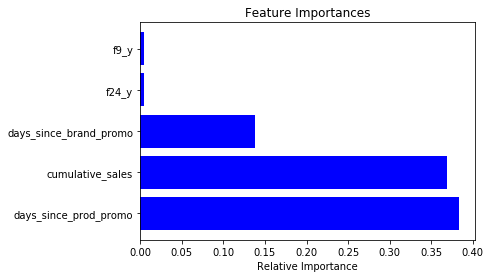

Top 5 important features in descending order:
 ['days_since_prod_promo' 'cumulative_sales' 'days_since_brand_promo'
 'f24_y' 'f9_y']


Features f0 through f29 with _x (_y) appended are product (brand) promotion features.


Out of bag score for classification: 0.86
              precision    recall  f1-score   support

         0.0       0.97      0.86      0.91       416
         1.0       0.44      0.80      0.57        59

    accuracy                           0.85       475
   macro avg       0.70      0.83      0.74       475
weighted avg       0.90      0.85      0.87       475



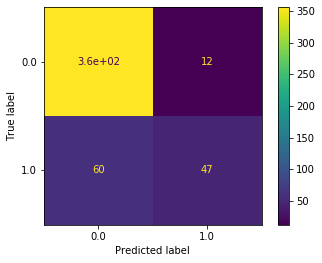

Accuracy score for training set: 1.00
Accuracy score for test set: 0.85
Precision score for test set: 0.80
Recall score for test set: 0.44
1242


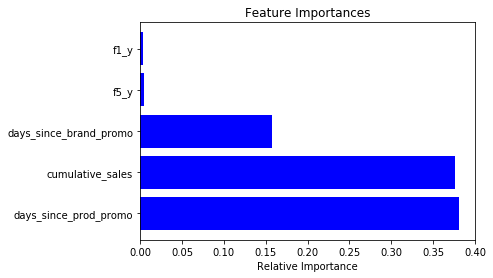

Top 5 important features in descending order:
 ['days_since_prod_promo' 'cumulative_sales' 'days_since_brand_promo'
 'f5_y' 'f1_y']


Features f0 through f29 with _x (_y) appended are product (brand) promotion features.


Out of bag score for classification: 0.86
              precision    recall  f1-score   support

         0.0       0.96      0.91      0.93       408
         1.0       0.59      0.78      0.68        69

    accuracy                           0.89       477
   macro avg       0.78      0.85      0.80       477
weighted avg       0.91      0.89      0.90       477



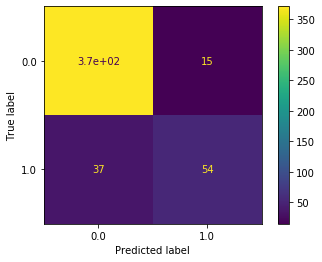

Accuracy score for training set: 1.00
Accuracy score for test set: 0.89
Precision score for test set: 0.78
Recall score for test set: 0.59
6879


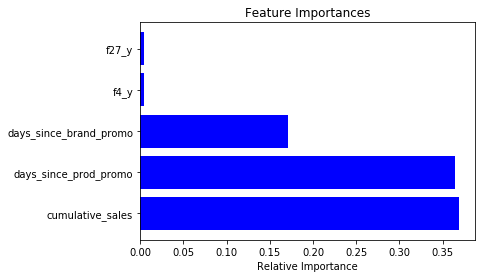

Top 5 important features in descending order:
 ['cumulative_sales' 'days_since_prod_promo' 'days_since_brand_promo'
 'f4_y' 'f27_y']


Features f0 through f29 with _x (_y) appended are product (brand) promotion features.


Out of bag score for classification: 0.83
              precision    recall  f1-score   support

         0.0       0.95      0.83      0.89       401
         1.0       0.46      0.79      0.58        75

    accuracy                           0.82       476
   macro avg       0.71      0.81      0.73       476
weighted avg       0.88      0.82      0.84       476



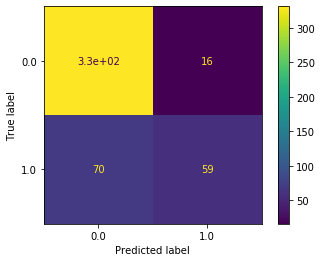

Accuracy score for training set: 1.00
Accuracy score for test set: 0.82
Precision score for test set: 0.79
Recall score for test set: 0.46
216


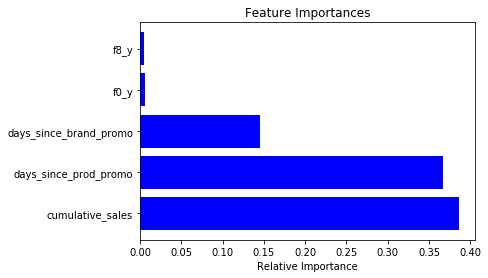

Top 5 important features in descending order:
 ['cumulative_sales' 'days_since_prod_promo' 'days_since_brand_promo'
 'f0_y' 'f8_y']


Features f0 through f29 with _x (_y) appended are product (brand) promotion features.


Out of bag score for classification: 0.86
              precision    recall  f1-score   support

         0.0       0.97      0.88      0.93       408
         1.0       0.55      0.84      0.66        68

    accuracy                           0.88       476
   macro avg       0.76      0.86      0.79       476
weighted avg       0.91      0.88      0.89       476



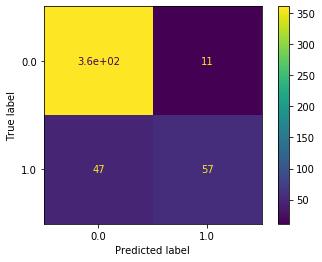

Accuracy score for training set: 1.00
Accuracy score for test set: 0.88
Precision score for test set: 0.84
Recall score for test set: 0.55
2702


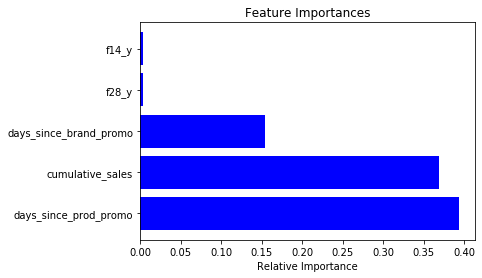

Top 5 important features in descending order:
 ['days_since_prod_promo' 'cumulative_sales' 'days_since_brand_promo'
 'f28_y' 'f14_y']


Features f0 through f29 with _x (_y) appended are product (brand) promotion features.


Out of bag score for classification: 0.82
              precision    recall  f1-score   support

         0.0       0.93      0.82      0.87       394
         1.0       0.45      0.70      0.55        81

    accuracy                           0.80       475
   macro avg       0.69      0.76      0.71       475
weighted avg       0.85      0.80      0.82       475



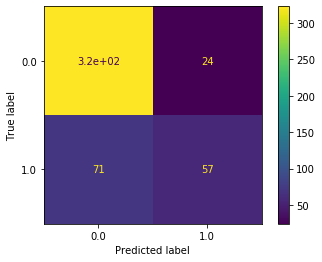

Accuracy score for training set: 1.00
Accuracy score for test set: 0.80
Precision score for test set: 0.70
Recall score for test set: 0.45


*------------------------*
Overall performance of the model on a number of products:
Average accuracy of hold-out set on sampling products: 0.85
Average out of bag score for sampling products: 0.85


P-values for product promotions' correlation with sales: 
 [2.2713218503118512e-14, 0.03072038290278887, 0.4008082812668206, 0.04311240995123497, 0.947366285196231]
P-values for brand promotions' correlation with sales
 [0.48868487319753423, 0.21705452405831643, 0.8876745316455439, 0.005391735349398736, 0.7857436170792451]


In [15]:
if __name__ == '__main__':
    
    
    # Randomly pick 50 products out of 10,000s:
    #idx = random.sample(range(1, 10000), 2)
    idx = [8050, 1242, 6879, 216, 2702]
    brand_promo, product_promo, prod_oos, prod_sales = load_data()
    acc, oob, p_value_product, p_value_brand = [], [], [], []
    for product_id in idx:
        print(product_id)
        
        df = predict_prod_oos(brand_promo, product_promo, prod_oos, prod_sales, product_id)
        accuracy, oob_score= train_model(df)
        
        acc.append(accuracy)
        oob.append(oob_score)
        
        # Investigate correlation between brand and product promos with respect to sales
        pearson1, p_val1 = pearsonr(df.days_since_brand_promo, df.sales)
        pearson2, p_val2 = pearsonr(df.days_since_prod_promo, df.sales)
        
        p_value_brand.append(p_val1)
        p_value_product.append(p_val2)
        
    print("\n")
    print('*------------------------*')
    print("Overall performance of the model on a number of products:")
    print('Average accuracy of hold-out set on sampling products: {:.2f}'.format(np.mean(acc)))
    print('Average out of bag score for sampling products: {:.2f}'.format(np.mean(oob)))
    #print('Average p_value for product promotion for sampling products: {:.2f}'.format(p_value_product))
    #print('Average p_value for brand promotion for sampling products: {:.2f}'.format(p_value_brand))
    print("\n")
    print("P-values for product promotions' correlation with sales: \n", p_value_product)
    print("P-values for brand promotions' correlation with sales\n",p_value_brand)

#### Visualize sales trends

Days since product promotions started vs. sales:


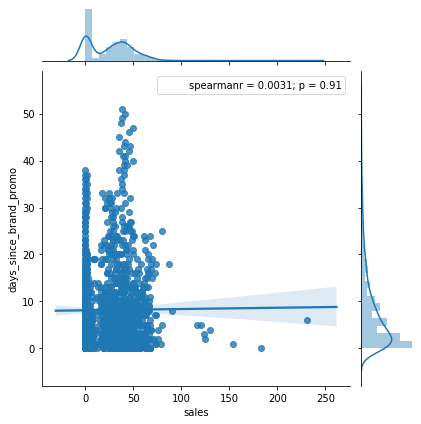

In [26]:
print("Days since product promotions started vs. sales:")
g = sns.jointplot(x='sales', y='days_since_brand_promo', data=df, kind='reg')
g = g.annotate(stats.spearmanr)

Days since brand promotions started vs. sales


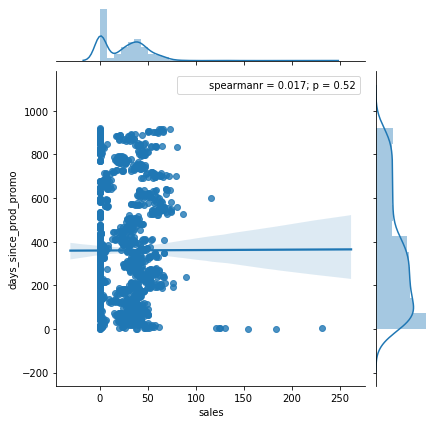

In [24]:
print("Days since brand promotions started vs. sales:")
g = sns.jointplot(x='sales', y='days_since_prod_promo', data=df, kind='reg')
g = g.annotate(stats.spearmanr)


### Key findings:

#### 1- No strong correlation between the total number of promotions (product or brand) and the cumulative sales for the associated product

#### 2- Statistically significant negative correlation between days since last brand promo and daily sales

#### 3- no significant correlation between last product promo and daily sales

#### This suggests that there may be a short term sales bump resulting from promotions that dies away in a couple of days.

#### More information about the duration and ending of promotions is needed to draw conclusions from this insight.